# Lihat.in For Skripsi :)

 importing base module

In [1]:
import os
import pandas as pd
import numpy as np

import splitfolders


from datetime import datetime

those modules mainly for preparing data before its comes to preprocessing, etc

In [2]:
#Main Direcory

base_dir = 'Data'

In [3]:
#Split Scenario

scene = [
    # [0.7,0.3],
    [0.75,0.25],
    # [0.8,0.2]
]

# # #For god sake, doit once
# for i,scenerios in enumerate(scene):
#     splitfolders.ratio(base_dir, output=f"Split_Segmented/skenario-{i+1}", ratio=(scenerios[0],scenerios[1]), group_prefix=None,seed=42)

#Skenario 1
train_dir1 = "New_splitted_data/skenario-1/train"
val_dir1 = "New_splitted_data/skenario-1/val"

#Skenario 2
train_dir2 = "New_splitted_data/skenario-2/train"
val_dir2 = "New_splitted_data/skenario-2/val"

#Skenario 3
train_dir3 = "New_splitted_data/skenario-3/train"
val_dir3 = "New_splitted_data/skenario-3/val"

In [4]:
def built_dataframe(dir = base_dir,):

    '''
        A Function to create a Dataframe containing Paths and Classes
    '''


    df = pd.DataFrame({
        'Path':[],
        'Class':[]
    })

    for label in os.listdir(dir):
        for data in os.listdir(dir+f"/{label}"):
            df = df.append({
                'Path':f"{dir}/{label}/{data}",
                'Class':label
            },ignore_index = True)

    return df 

In [5]:
def create_reportsDir(time):
    '''
        A function to create a directory for observing classsification reports
    '''

    if os.path.exists(f'reports/{time}') == False:
        os.mkdir(f'reports/{time}')

    return None

In [6]:
def get_currentTime():

    '''
        A function to get the current time. Mainly for Reports Name
    '''

    now  = datetime.now().strftime("%b%d%Y-%H.%M.%S")
    create_reportsDir(now)
    return now

## Preprocessing

Importing important modules

In [7]:
import tensorflow as tf


import matplotlib.pyplot as plt


from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



import h5py

In [8]:
#Utilizing GPU

if tf.config.list_physical_devices('GPU'):
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
    rotation_range= 15,
    width_shift_range= 10.0,
    height_shift_range= 10.0,

    )

val_gen = ImageDataGenerator(
    rescale=1./255,
    )

In [10]:
def generators(data_train,data_val,train_datagen,val_datagen,bs,resize_shape=(224,224)):

    '''
        A function to crete the generator
    '''

    train_generator = train_datagen.flow_from_dataframe(
                dataframe=data_train,
                x_col='Path',
                y_col='Class',
                target_size=resize_shape,
                batch_size=bs,
                class_mode='categorical'
            )
            
            
    val_generator = val_datagen.flow_from_dataframe(
                dataframe=data_val,
                x_col='Path',
                y_col='Class',
                target_size=resize_shape,
                batch_size=bs,
                shuffle=False,
                class_mode='categorical'
            )
    
    return train_generator, val_generator

## Training Model

Using MobileNetV2 as Base Feature Extractor

In [11]:
IMG_SHAPE = (224, 224, 3)

mobileNetV2_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False,
    alpha=1.0, weights='imagenet',)

mobileNetV2_model.trainable = True

Defining important Function such as plotting graph, fitting model, etc

In [12]:
def plot_accLost(history):
    # Retrieve a list of accuracy results on training and validation data
    # sets for each training epoch
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    # Retrieve a list of list results on training and validation data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and validation accuracy')

    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and validation loss')


    plt.show()

In [13]:
def fitting_model(EPOCHS,train,val,base_model = mobileNetV2_model,num_classes =7):
    model = tf.keras.models.Sequential()

    model.add(base_model)

    model.add(tf.keras.layers.GlobalAveragePooling2D()),
    model.add(tf.keras.layers.Dense(128, activation='relu')),
    model.add(tf.keras.layers.Dropout(0.2)),
    model.add(tf.keras.layers.Dense(32, activation='relu')),
    model.add(tf.keras.layers.Dropout(0.2)),
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['categorical_accuracy'])
    
    history = model.fit(
      train,
      epochs=EPOCHS,
      validation_data=val,  
      verbose=0)
    
    
    plot_accLost(history)
  
    
    return model
    

In [14]:
def write_report(path,report_name,report,i):
    filename = f"reports/{path}/Report {report_name}.txt"
    
    if os.path.exists(filename):
        with open(filename,'a') as file:
            file.write(f"Batch : {i} Classification report:\n{report}\n")
    else:
        with open(filename,'w') as file:
            file.write(f"Batch : {i} Classification report:\n{report}\n")

In [15]:
batches = [
    # 8,
    16,
    # 32
    ]

scenarios = [
    # [train_dir1,val_dir1],
    [train_dir2,val_dir2],
    # [train_dir3,val_dir3],
]

Fitting Model

========Skenario 75.0:25.0========
Found 1254 validated image filenames belonging to 7 classes.
Found 656 validated image filenames belonging to 7 classes.


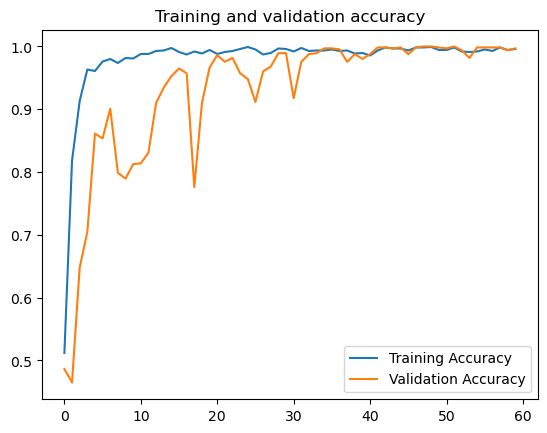

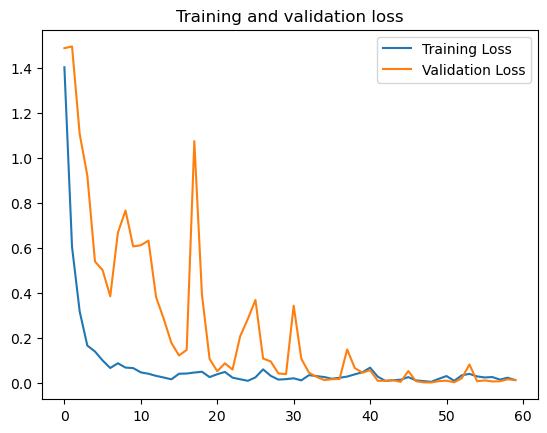

Skenario 75.0:25.0 | BATCH SIZE :16 classification report:
              precision    recall  f1-score   support

      Rp1000       1.00      1.00      1.00       107
     Rp10000       1.00      0.98      0.99        82
    Rp100000       1.00      1.00      1.00       124
      Rp2000       1.00      1.00      1.00        77
     Rp20000       1.00      1.00      1.00       106
      Rp5000       1.00      1.00      1.00        81
     Rp50000       0.98      1.00      0.99        79

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656




In [17]:
now = get_currentTime()

for i, scenario in enumerate(scenarios):
    print(f"{'='*8}Skenario {scene[-1][0]*100}:{scene[-1][1]*100}{'='*8}")

    reportName = f"{now}_10-4LR-MobileNetV2VanillaWDropout0.2#2-Main Scenario"
    for batch in batches:
    
        train_df = built_dataframe(scenario[0])
        val_df = built_dataframe(scenario[1])

        train_generator,val_generator = generators(train_df,val_df,datagen,val_gen,batch)

        model = fitting_model(60,train_generator,val_generator)
        # plt.savefig(f"Skenario {scene[i][0]*100}_{scene[i][1]*100}-{batch}.jpg")
        
        
        val_generator.reset()
        Y_pred = model.predict(val_generator)
        y_pred = np.argmax(Y_pred, axis=1)
        target_names = train_generator.class_indices.keys()

    
        report = (classification_report(val_generator.classes, y_pred, target_names=target_names))
        print(f"Skenario {scene[i][0]*100}:{scene[i][1]*100} | BATCH SIZE :{batch} classification report:\n{report}\n")


        write_report(now,reportName,report,batch)    

## Model Selection and Testing

Model Selection


In [19]:
#Selected Trait : Scene #3 | 16 BS


train_df = built_dataframe(train_dir2)
val_df = built_dataframe(val_dir2)

Found 1254 validated image filenames belonging to 7 classes.
Found 656 validated image filenames belonging to 7 classes.


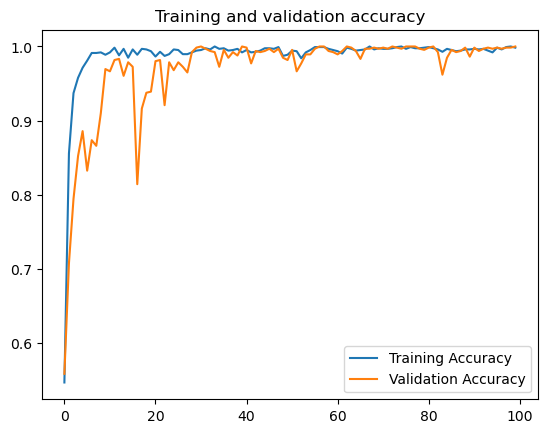

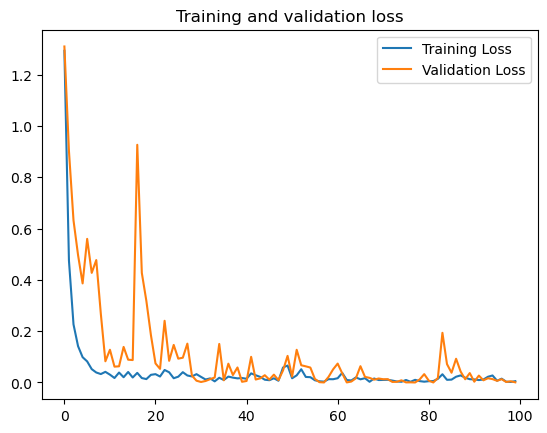

In [20]:
train_generator,val_generator = generators(train_df,val_df,datagen,val_gen,16)

model = fitting_model(100,train_generator,val_generator)

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open('Model/1x128+1x32-0.2Dr-0.0001LR-Mnetv2-glblplb2d-100Epoch.tflite','wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\intel\AppData\Local\Temp\tmpx9usfvqa\assets


INFO:tensorflow:Assets written to: C:\Users\intel\AppData\Local\Temp\tmpx9usfvqa\assets
d:\Anaconda\envs\mycvenv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Testing

In [22]:
#TEST

from PIL import Image

data = [
    "Data/Rp1000/0.jpg","Data/Rp1000/10.jpg",
    "Data/Rp10000/0.jpg","Data/Rp10000/10.jpg",
    "Data/Rp20000/0.jpg","Data/Rp20000/10.jpg",
    "Data/Rp2000/0.jpg","Data/Rp2000/2k13.jpg",
    "Data/Rp5000/27.jpg","Data/Rp5000/37.jpg",
    "Data/Rp50000/0.jpg","Data/Rp50000/10.jpg",
    "Data/Rp100000/0.jpg","Data/Rp100000/10.jpg",
    "1.jpeg", "1 (3).jpeg",
    "50k.jpg",
    "100k.jpg",
    "50K (1).jpeg","50K (2).jpeg",
    "50K (3).jpeg","50K (4).jpeg",
    "50K (5).jpeg","50K (6).jpeg",
    "Screenshot_2023-04-09-13-57-05-793_com.example.we_see.jpg"
]

In [19]:
def segment(path,model = 'myUNET_model-Dropout0.2-4Layer.tflite'):
    interpreter = tf.lite.Interpreter(model_path=model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    img = Image.open(path)
    #  Resize the photo
    img = np.array(img.resize((256,256)))/255.
    img = img[:,:,0:3]


    # Convert the photo to a tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # Normalize the tensor
    # img_tensor = tf.image.per_image_standardization(img_tensor)

    # Add batch dimension
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    # Perform inference
    interpreter.set_tensor(input_details[0]['index'], img_tensor)
    interpreter.invoke()
    
    output_details = interpreter.get_output_details()
    output = interpreter.get_tensor(output_details[0]['index'])

    mask = output.squeeze()
    mask = np.stack((mask,)*3, axis=-1)
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0

    img = img*mask

    plt.axis('off')
    plt.imshow(img)
    plt.show()

    # print(img.shape)

    img = Image.fromarray(((img)*255).astype(np.uint8))

    # print(image)

    img = np.array(img.resize((224,224)),dtype = np.float32)
    img = img*(1./255)


    #Show Image
    plt.imshow(img)

    img = tf.convert_to_tensor(img)
    # img = tf.image.per_image_standardization(img)
    img = tf.expand_dims(img, axis=0)


    #Predict Image
    interpreter = tf.lite.Interpreter(f"Model/Segmented-0.001DR-0.0001LR-VanillaMnetSGDOPT.tflite")
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()



    interpreter.set_tensor(input_details[0]["index"], img)
    interpreter.invoke()


    output_details = interpreter.get_output_details()
    output_data = interpreter.get_tensor(output_details[0]["index"])


    classes = {
        0:"Rp 1.000",
        1:"Rp 10.000",
        2:"Rp 100.000",

        3:"Rp 2.000",
        4:"Rp 20.000",

        5:"Rp 5.000",
        6:"Rp 50.000"
    }


    print(classes[np.argmax(output_data)])


In [23]:

def predict(path,model):
    #Image Test Path
    filepath = path

    #Open Image
    img = Image.open(filepath)

    #Preprocess Image
    img = np.array(img.resize((224,224)),dtype = np.float32)
    img = img*(1./255)


    #Show Image
    plt.imshow(img)
    plt.show()

    img = tf.convert_to_tensor(img)
    # img = tf.image.per_image_standardization(img)
    img = tf.expand_dims(img, axis=0)


    #Predict Image
    interpreter = tf.lite.Interpreter(f"Model/{model}.tflite")
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()



    interpreter.set_tensor(input_details[0]["index"], img)
    interpreter.invoke()


    output_details = interpreter.get_output_details()
    output_data = interpreter.get_tensor(output_details[0]["index"])


    classes = {
        0:"Rp 1.000",
        1:"Rp 10.000",
        2:"Rp 100.000",

        3:"Rp 2.000",
        4:"Rp 20.000",

        5:"Rp 5.000",
        6:"Rp 50.000"
    }


    print(classes[np.argmax(output_data)])


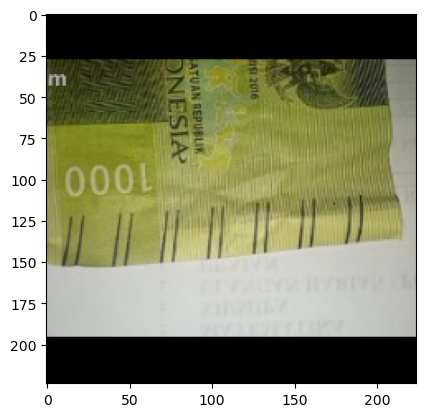

Rp 1.000


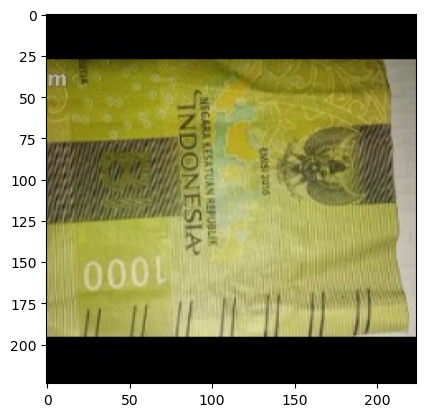

Rp 1.000


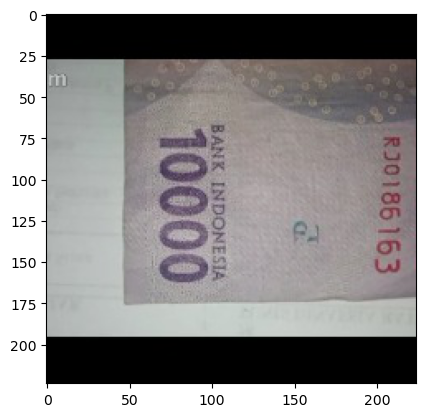

Rp 10.000


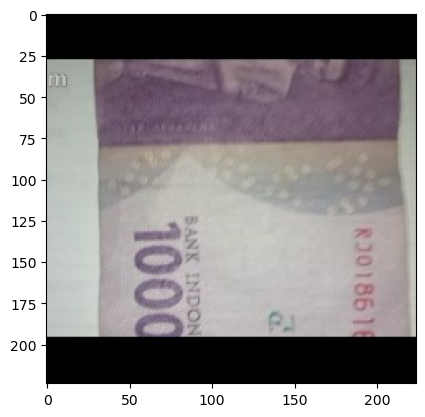

Rp 10.000


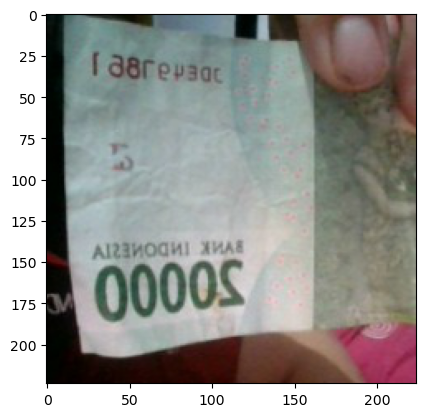

Rp 20.000


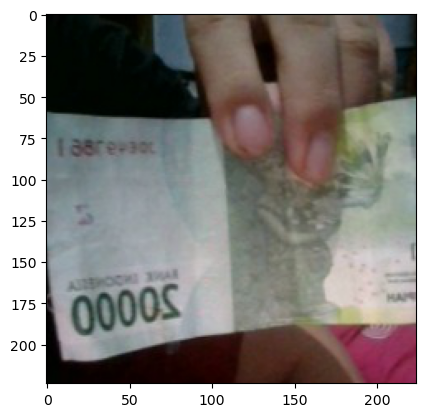

Rp 20.000


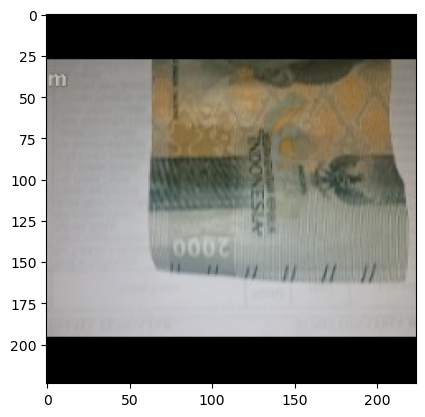

Rp 2.000


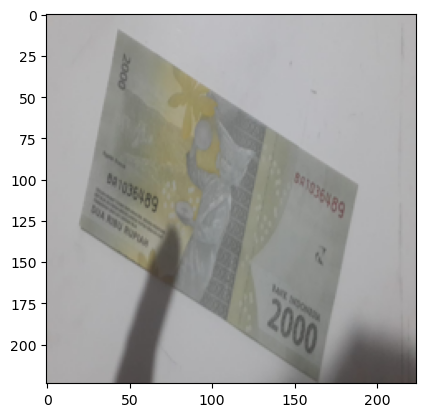

Rp 5.000


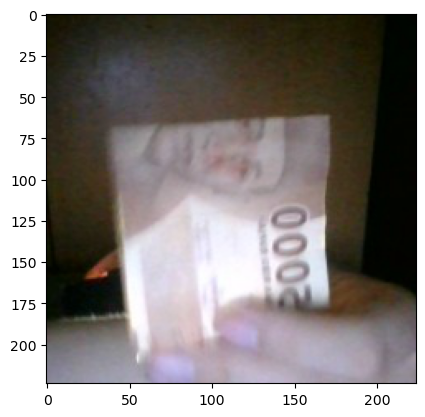

Rp 5.000


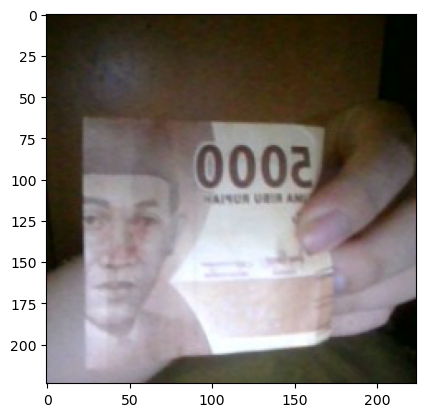

Rp 5.000


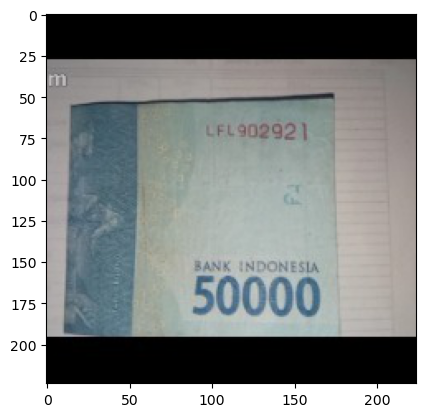

Rp 50.000


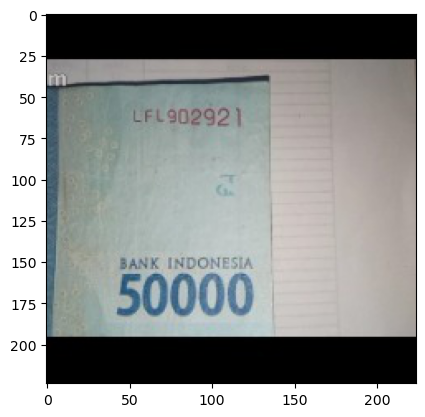

Rp 50.000


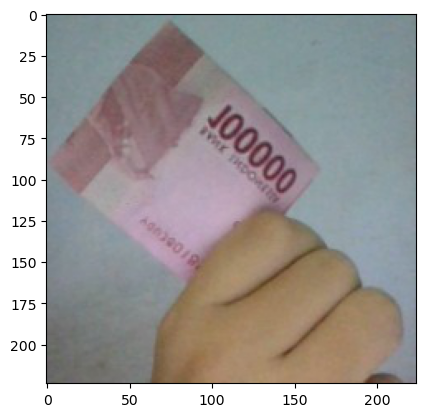

Rp 100.000


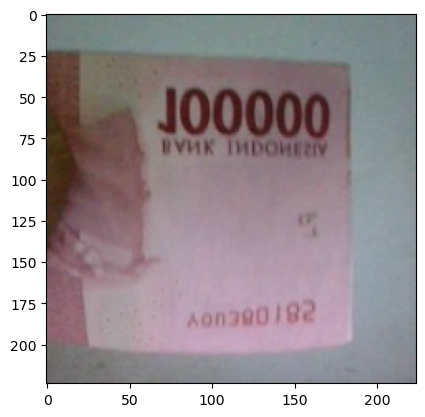

Rp 100.000


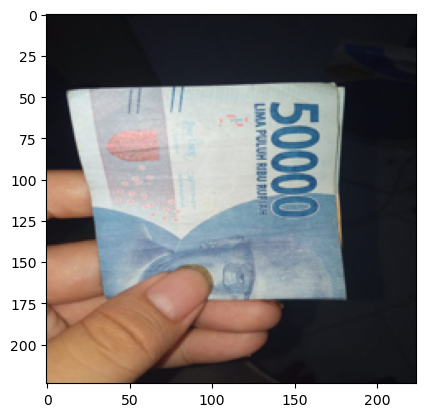

Rp 50.000


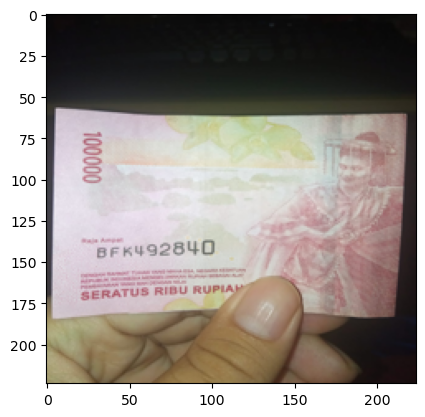

Rp 100.000


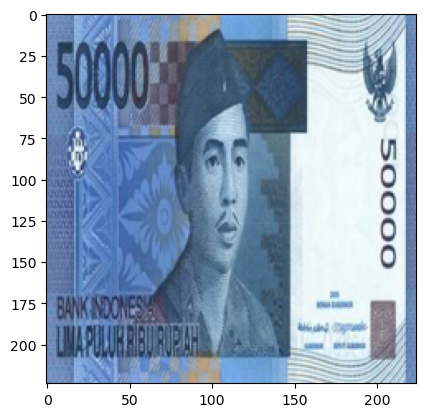

Rp 5.000


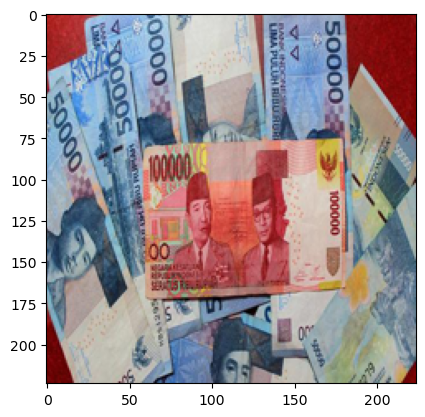

Rp 100.000


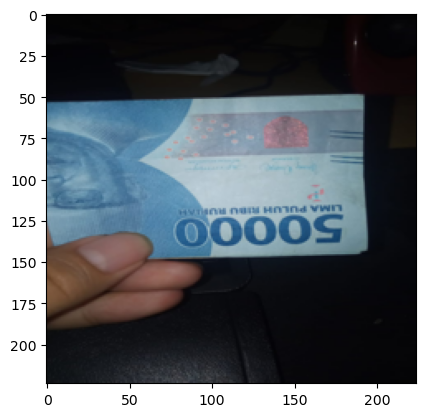

Rp 50.000


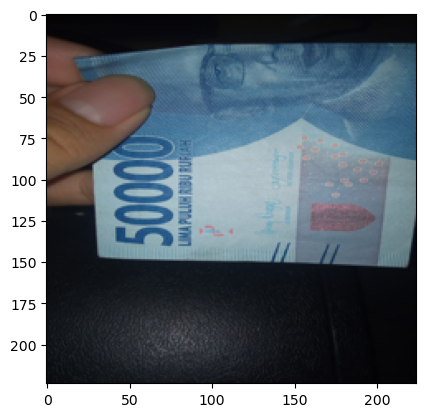

Rp 50.000


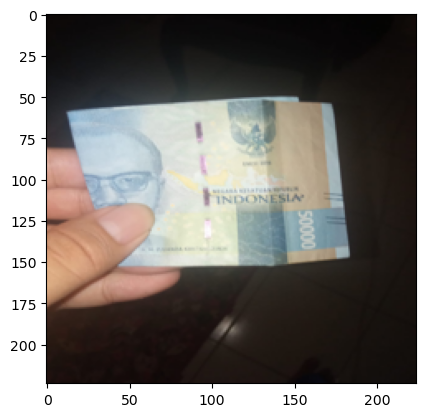

Rp 5.000


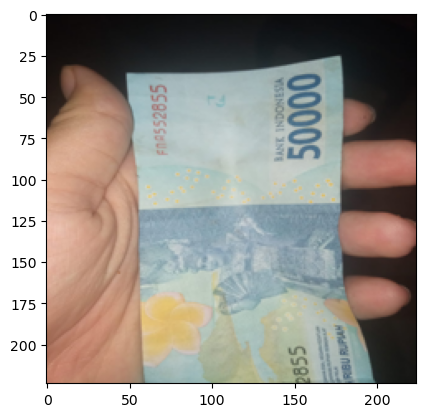

Rp 50.000


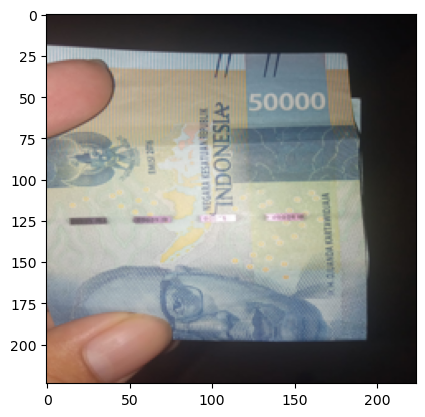

Rp 50.000


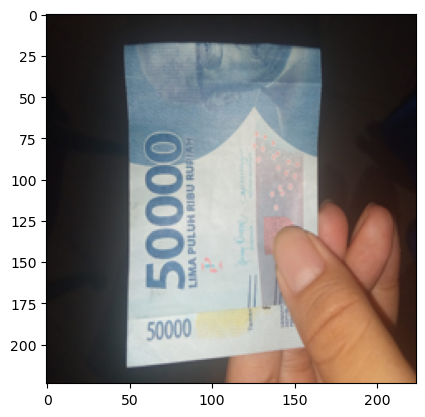

Rp 50.000


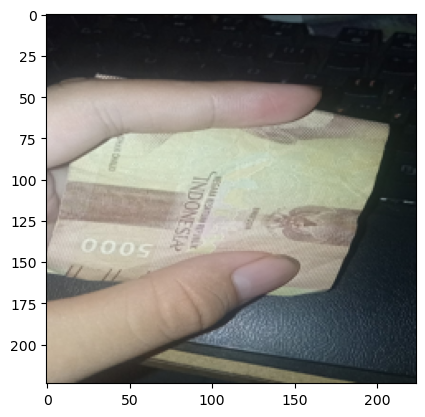

Rp 2.000


In [24]:
for path in data:
    # plt.imshow(path)
    # segment(path)
    (predict(path,"1x128+1x32-0.2Dr-0.0001LR-Mnetv2-glblplb2d-100Epoch"))
    # plt.title(path)
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()
    print("="*15)